In [1]:
from IPython import display

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import time

In [2]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

def preprocess_images(images):
    images = images/255.0
    return images

train_images = preprocess_images(train_images)
test_images = preprocess_images(test_images)
BUFFER = 25000
BATCH_SIZE = 32

train_dataset = (tf.data.Dataset.from_tensor_slices((train_images,train_labels))
                 .shuffle(BUFFER).batch(BATCH_SIZE))
test_dataset = (tf.data.Dataset.from_tensor_slices((test_images, test_labels))
                 .shuffle(BUFFER).batch(BATCH_SIZE))

Metal device set to: Apple M2


In [3]:
class AccentuatedLayer(tf.keras.layers.Layer):
    def __init__(self, emb_dim,w,h, kernels,d=1, name=None):
        super(AccentuatedLayer, self).__init__(name=name)
        self.emb_dim = emb_dim*d
        self.projected_emb = tf.keras.layers.Dense(self.emb_dim, activation='tanh', trainable=True)
        self.pattern_kernels = tf.Variable(tf.random_normal_initializer()(shape=[kernels,w,h,d,emb_dim], dtype=tf.float32),trainable=True)
        self.flatten = tf.keras.layers.Flatten()
    
    def compute_cosine_sim(self, a, b):
        normalize_a = tf.nn.l2_normalize(a,1)        
        normalize_b = tf.nn.l2_normalize(b,1)
        sim = tf.matmul(normalize_a, normalize_b, transpose_b=True)
        return sim
    
    def call(self, inputs, hidden_smx=None):
        embs = self.projected_emb(inputs)
        similarity = self.compute_cosine_sim(self.flatten(embs),self.flatten(self.pattern_kernels))
        smx = tf.math.softmax(similarity)
        if hidden_smx is None:
            cell_outs = tf.einsum('ijkl,im->ijklm', embs, smx)
            return cell_outs, smx
        else:
            sidx = tf.argsort(hidden_smx)
            weighted_scores = tf.gather(tf.cumsum(tf.sort(hidden_smx,axis=1),axis=1),sidx,axis=1, batch_dims = 1)
            sofsm = tf.einsum("ij,ijk->ijk",weighted_scores,smx)
            cell_outs = tf.reduce_sum(tf.einsum("ijk,ijl->ijlk",embs,sofsm),axis=1)
            return cell_outs, tf.reduce_sum(smx,axis=1)

In [4]:
inp_layer = tf.keras.layers.Input(shape=(32,32,3))

cell, hid = AccentuatedLayer(32,w=32,h=32,d=3,kernels=16,name=f"AccLayer1")(inp_layer)
dp = tf.keras.layers.Dropout(0.2)(cell)
flt = tf.keras.layers.Flatten()(dp)
outl = tf.keras.layers.Dense(10,activation='softmax')(flt)

model = tf.keras.Model(inputs=inp_layer,outputs=outl)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 AccLayer1 (AccentuatedLayer  ((None, 32, 32, 96, 16),  1573248  
 )                            (None, 16))                        
                                                                 
 dropout (Dropout)           (None, 32, 32, 96, 16)    0         
                                                                 
 flatten_1 (Flatten)         (None, 1572864)           0         
                                                                 
 dense_1 (Dense)             (None, 10)                15728650  
                                                                 
Total params: 17,301,898
Trainable params: 17,301,898
Non-trainable params: 0
_________________________________________________

In [5]:
model.compile(loss='sparse_categorical_crossentropy',optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001),metrics=['acc'])

In [6]:
history = model.fit(train_dataset,epochs = 5, validation_data=test_dataset )

Epoch 1/5


2023-05-12 12:42:48.381986: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1563/1563 [==============================] - 241s 154ms/step - loss: 1.8207 - acc: 0.3954 - val_loss: 1.7123 - val_acc: 0.4101
Epoch 2/5
1563/1563 [==============================] - 240s 153ms/step - loss: 1.6224 - acc: 0.4400 - val_loss: 1.6782 - val_acc: 0.4157
Epoch 3/5
1563/1563 [==============================] - 254s 162ms/step - loss: 1.5739 - acc: 0.4552 - val_loss: 1.6534 - val_acc: 0.4109
Epoch 4/5
1563/1563 [==============================] - 242s 155ms/step - loss: 1.5446 - acc: 0.4662 - val_loss: 1.6104 - val_acc: 0.4389
Epoch 5/5
1563/1563 [==============================] - 242s 155ms/step - loss: 1.5117 - acc: 0.4767 - val_loss: 1.6102 - val_acc: 0.4296


In [39]:
vis_model = tf.keras.Model(inputs=inp_layer,outputs=[cell,hid])
vis_model

In [78]:
o,h= vis_model(test_images[:50])

In [79]:
o.shape

TensorShape([50, 32, 32, 96, 16])

In [80]:
def plot(out,hid,no=0):
    out = out[no]
    j = np.argmax(h[no])
    fig = plt.figure(figsize=(8, 8))
    for i in range(out.shape[-1]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(out[:, :, i,j],cmap='gray')
        plt.axis('off')
    plt.show()

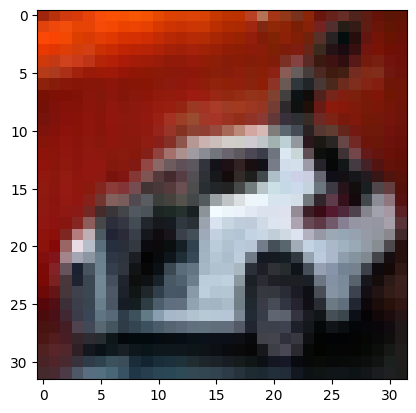

In [101]:
plt.imshow(test_images[6]);

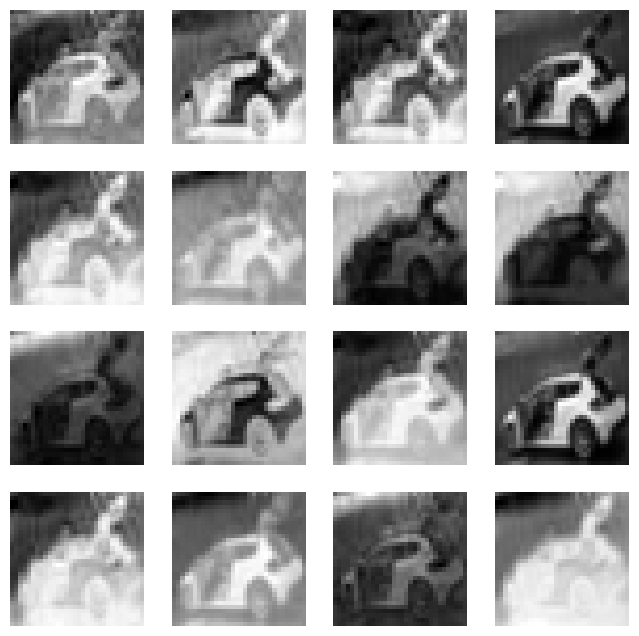

In [102]:
plot(o,h,no = 6)

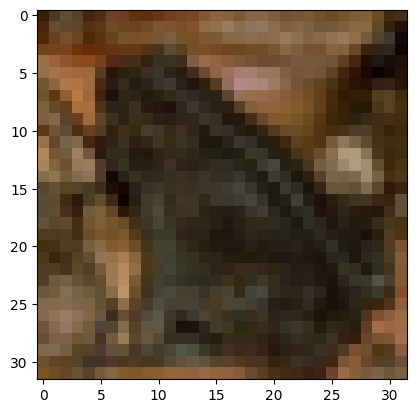

In [87]:
plt.imshow(test_images[30]);

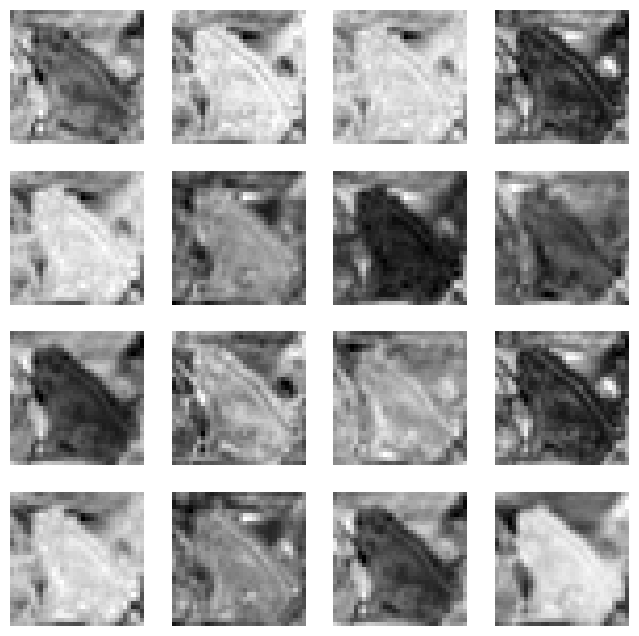

In [88]:
plot(o,h,no = 30)

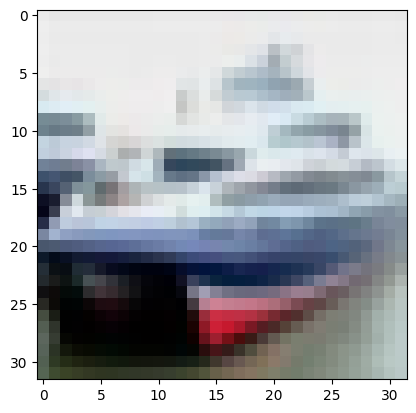

In [90]:
plt.imshow(test_images[1]);

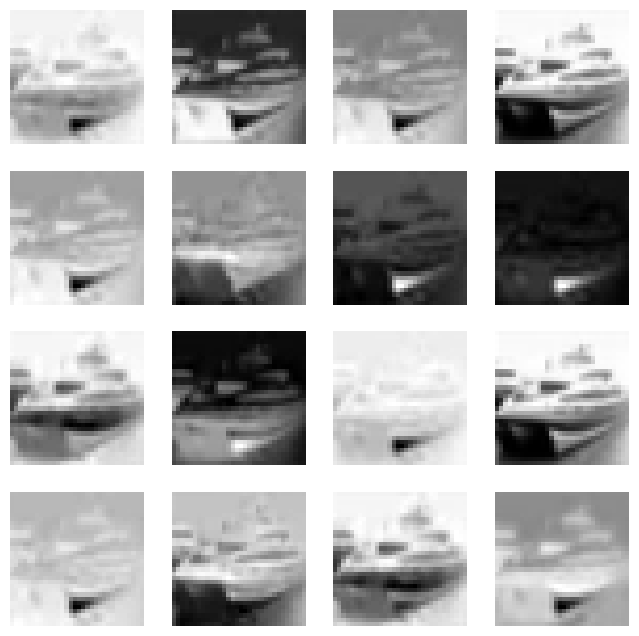

In [91]:
plot(o,h,no = 1)

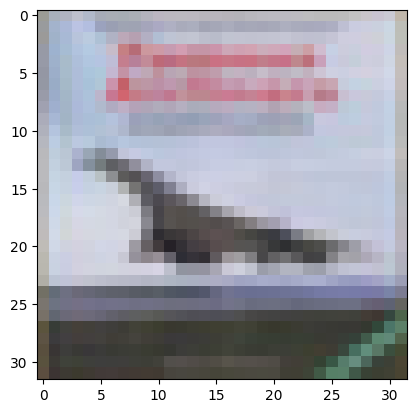

In [92]:
plt.imshow(test_images[3]);

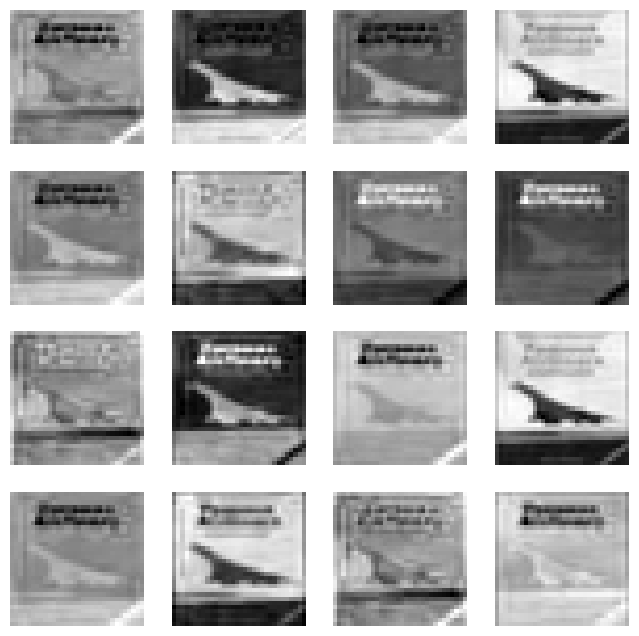

In [93]:
plot(o,h,no = 3)

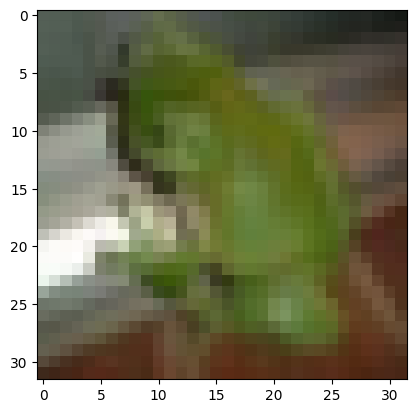

In [95]:
plt.imshow(test_images[7]);

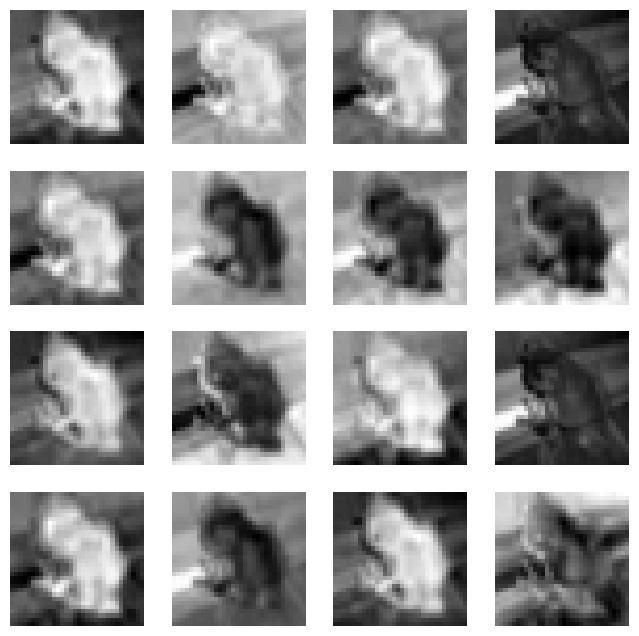

In [96]:
plot(o,h,no = 7)